# **Welcome to our project report! ✨🧪**
## 🚀 *Overview*
🤯 Acquiring Dataset <br>
🧹 Cleaning Dataset <br>
&nbsp;&nbsp;&nbsp;&nbsp; 🛟 Saving the cleaned data to a csv file


## 🤯 *Acquiring Dataset*
In a first step, we will acquire the [pKa dataset](https://github.com/cbio3lab/pKa/blob/main/Data/test_acids_bases_descfinal_nozwitterions.csv) from cbio3lab's repository, initially extracted from the Harvard [dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6A67L9).

Next, we will perform an exploratory analysis of the collected dataset.

1) Let's download the data directly into your working directory:

In [136]:
import requests
from pathlib import Path

# Correct raw file URL
url = "https://raw.githubusercontent.com/anastasiafloris/pKaPredict/main/data/pkadatasetRAWDATA.csv"

# Get the repository root by going up one level from the current working directory
repo_root = Path.cwd().parent  # Moves one level up from "notebooks" (if running from there)

# Define the correct save directory inside the repo's "data" folder
save_dir = repo_root / "data"
save_dir.mkdir(parents=True, exist_ok=True)  # Ensure the "data" folder exists

# Define the full file path
file_path = save_dir / "pkadatasetRAWDATA.csv"

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request fails

    # Check if the content is an HTML page (meaning it's the wrong link)
    if "<!DOCTYPE html>" in response.text:
        print("❌ Error: This is an HTML page, not the CSV file. Check your URL.")
    else:
        with open(file_path, "wb") as file:  # Save inside "data" folder of the repo
            file.write(response.content)
        print(f"✅ File downloaded successfully: {file_path}")

except requests.exceptions.RequestException as e:
    print(f"❌ Failed to download file: {e}")


✅ File downloaded successfully: /Users/anastasiafloris/Desktop/pKaPredict/pKaPredict/data/pkadatasetRAWDATA.csv


2) Let's open the file and verify its existence as well as display a preview of the latter:

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Define the current working directory
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

# Specify the path to the dataset file (as a string)
file_path = os.path.join("..", "data", "pkadatasetRAWDATA.csv")

# Convert file_path (string) to a Path object before checking existence
file_path_obj = Path(file_path)

# Verify the file's existence and read its contents if available
if file_path_obj.exists():  # ✅ Use the Path object to check existence
    print("The dataset file exists. Reading the file contents...\n")
    
    # Open and display the contents (optional, for verification)
    with file_path_obj.open("r", encoding="utf-8") as file:  # ✅ Use Path object to open
        content = file.read()
        print(content[:100])  # Print only the first 100 characters for preview
    
    # Load the dataset using pandas
    try:
        data_pka = pd.read_csv(file_path, delimiter=",")  # ✅ Still using the original string path
        print("\n✅ Dataset successfully loaded. Preview:")
        
        # Display interactive scrollable table in VS Code/Jupyter
        from IPython.display import display
        display(data_pka.head(10))  # Display first 10 rows
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")

else:
    print("❌ Error: The specified file does not exist.")




Current Directory: /Users/anastasiafloris/Desktop/pKaPredict/pKaPredict/notebooks
The dataset file exists. Reading the file contents...

Compound,set,Smiles,pka,prot_smiles,deprot_smiles,acid_base_type,acid_base_string,prot_charge,deprot

✅ Dataset successfully loaded. Preview:


,Compound,set,Smiles,pka,prot_smiles,deprot_smiles,acid_base_type,acid_base_string,prot_charge,deprot_charge,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,4,test,Brc1ccc(-c2nn[nH]n2)cc1,3.73,Brc1ccc(-c2nn[nH]n2)cc1,Brc1ccc(-c2nn[n-]n2)cc1,acidic,A,0,-1,...,16.98,0.09,-0.05,0.01,0.01,0.00,1,3,7.42,23.10
1,6,test,Brc1ccc(C2NCCS2)cc1,5.05,Brc1ccc(C2NCCS2)cc1,Brc1ccc(C2[NH2+]CCS2)cc1,basic,B,1,0,...,19.32,0.11,-0.07,0.02,0.01,0.00,1,1,15.16,29.56
2,7,test,Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1,7.00,Brc1ccc(Cc2c3ccccc3[nH+]c3ccccc23)cc1,Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1,basic,B,1,0,...,37.15,0.09,-0.04,-0.01,0.02,-0.01,0,1,17.91,48.69
3,18,test,Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1,11.30,Brc1cccc(Br)c1N(C1=[NH+]CCN1)C1CCCCC1,Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1,basic,B,1,0,...,111.84,0.24,-0.17,0.10,-0.04,-0.07,1,3,27.31,48.47
4,21,test,Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1,10.90,Brc1cccc(Br)c1N(CC1CCCC1)C1=[NH+]CCN1,Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1,basic,B,1,0,...,108.67,0.24,-0.18,0.11,-0.05,-0.07,1,3,27.31,48.47
5,29,test,Brc1ccccc1-c1nn[nH]n1,3.83,Brc1ccccc1-c1nn[nH]n1,Brc1ccccc1-c1nn[n-]n1,acidic,A,0,-1,...,32.50,0.09,-0.04,0.01,-0.04,0.02,1,3,7.42,23.10
6,35,test,Brc1cncc2ccccc12,3.54,Brc1c[nH+]cc2ccccc12,Brc1cncc2ccccc12,basic,B,1,0,...,26.29,0.10,-0.05,-0.02,0.03,-0.01,0,1,9.17,23.99
7,41,test,C#CC(C)(C)N(C)C(C)(C)C#C,6.65,C#CC(C)(C)N(C)C(C)(C)C#C,C#CC(C)(C)[NH+](C)C(C)(C)C#C,basic,B,1,0,...,13.00,0.11,-0.07,0.02,0.00,-0.00,0,1,20.56,31.80
8,52,test,C#CCCCC(=O)O,4.60,C#CCCCC(=O)O,C#CCCCC(=O)[O-],acidic,A,0,-1,...,4.66,0.20,-0.09,0.01,0.00,-0.06,1,2,9.70,17.50
9,62,test,C#CCCN,9.23,C#CCC[NH3+],C#CCCN,basic,B,1,0,...,1.17,0.05,-0.01,-0.02,0.01,0.00,1,1,6.99,12.81


## 🧹 *Cleaning Dataset*

✅ Prints initial dataset shape <br> 
✅ Counts and removes missing values (NaN) and duplicates <br>
✅ Prints final dataset shape after cleaning  <br>
✅ Generates a histogram to visualize pKa value distribution  <br>

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the dataset
file_path = os.path.join("..", "data", "pkadatasetRAWDATA.csv")

try:
    data_pka = pd.read_csv(file_path, sep=None, engine="python")  # Auto-detect delimiter
    print("✅ Dataset successfully loaded.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    data_pka = None

# Function to clean, remove duplicates, and visualize pKa distribution
def clean_and_visualize_pka(data_pka):
    """Cleans dataset by removing NaN values, duplicates, and visualizes pKa distribution."""
    
    if data_pka is None or data_pka.empty:
        print("❌ Error: Dataset is empty or not loaded.")
        return

    # Check initial shape
    print("\n🔹 Checking dataset information:")
    print(f"Initial dataset shape: {data_pka.shape}")

    # Ensure necessary columns exist
    required_columns = {"Smiles", "pka", "acid_base_type"}
    missing_columns = required_columns - set(data_pka.columns)
    if missing_columns:
        print(f"❌ Error: Missing required columns: {missing_columns}")
        return None
    
    # Select only the relevant columns and create a copy
    data_pka = data_pka[list(required_columns)].copy()
    
    # Check for missing values
    missing_values = data_pka.isnull().sum()
    print(f"\nMissing values before cleaning:\n{missing_values}")
    

    # Ensure "pka" column exists (case-sensitive)
    if "pka" not in data_pka.columns:
        print("❌ Error: 'pka' column not found in dataset.")
        return
    
    # Check for missing values
    missing_values = data_pka["pka"].isnull().sum()
    print(f"\nTotal missing values in 'pka': {missing_values}")

    # Drop NaN values
    data_pka.dropna(subset=["pka"], inplace=True)

    # Remove duplicates
    initial_rows = data_pka.shape[0]
    data_pka.drop_duplicates(inplace=True)
    final_rows = data_pka.shape[0]
    duplicates_removed = initial_rows - final_rows
    print(f"\nTotal duplicate rows removed: {duplicates_removed}")

    
    # Check final shape after cleaning
    print(f"Dataset shape after NaN and duplicate removal: {data_pka.shape}")

   
     

✅ Dataset successfully loaded.


📊 Present the pKa dataset as a histogram:


📊 Generating histogram for pKa distribution...



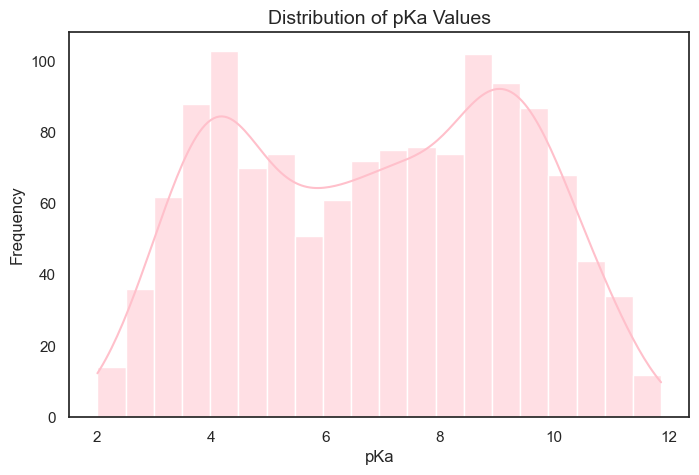

📁 Histogram saved successfully at: ../notebooks/Plots/pKa_distribution_of_the_dataset.png


In [139]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Generate histogram for pKa distribution
print("\n📊 Generating histogram for pKa distribution...\n")

# Set white background (removes grey Seaborn style)
sns.set_theme(style="white")

# Create figure
plt.figure(figsize=(8, 5))
sns.histplot(data=data_pka, x="pka", binwidth=0.5, kde=True, color="pink")  # Pink color

# Improve visual appearance
plt.xlabel("pKa", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of pKa Values", fontsize=14)
plt.grid(False)  # Removes any unwanted grid lines

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "pKa_distribution_of_the_dataset.png")

# Save histogram as PNG
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

# Success message
print(f"📁 Histogram saved successfully at: {save_path}")



### 🛟 *Saving the cleaned data to a CSV file*

In [140]:
# Call the function
cleaned_data = clean_and_visualize_pka(data_pka)

# Save the cleaned dataset to the correct folder inside your package
if cleaned_data is not None:
    save_path = os.path.join("..", "data", "pKadata_cleaned.csv")  # Ensure the correct path



    # Save as CSV
    cleaned_data.to_csv(save_path, index=False)
    print(f"✅ Cleaned dataset successfully saved at: {save_path}")


🔹 Checking dataset information:
Initial dataset shape: (1297, 274)

Missing values before cleaning:
acid_base_type    0
pka               0
Smiles            0
dtype: int64

Total missing values in 'pka': 0

Total duplicate rows removed: 0
Dataset shape after NaN and duplicate removal: (1297, 3)


## 🤓 *Computation of RDKit Molecular Descriptors*
Molecular descriptors are essential for pKa prediction using machine learning because they provide numerical representations of molecular structures, enabling the model to identify patterns and correlations between molecular features and pKa values.

In [143]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
from tqdm import tqdm

def RDkit_descriptors(smiles):
    """
    Compute RDKit molecular descriptors for a list of SMILES strings.

    Args:
        smiles (list): List of SMILES strings.

    Returns:
        tuple: (List of computed descriptor values, List of descriptor names)
    """
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors = []
    for mol in tqdm(mols, desc="Computing Molecular Descriptors"):
        if mol is not None:
            mol = Chem.AddHs(mol)  # Add hydrogens for better accuracy
            descriptors = calc.CalcDescriptors(mol)
            Mol_descriptors.append(descriptors)
        else:
            Mol_descriptors.append([None] * len(desc_names))  # Handle invalid SMILES

    return Mol_descriptors, desc_names

# Load cleaned data containing SMILES
file_path_cleaned = os.path.join("..", "data", "pKadata_cleaned.csv")
cleaned_data = pd.read_csv(file_path_cleaned)

# Compute descriptors
Mol_descriptors, desc_names = RDkit_descriptors(cleaned_data['Smiles'])

# Create DataFrame with descriptors and add SMILES column
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.insert(0, "Smiles", cleaned_data['Smiles'])  # Insert Smiles as the first column

# Save descriptors as CSV file in pkapredict/data
save_path = os.path.join("..", "data", "Data_pKa_Descriptors.csv")
df_descriptors.to_csv(save_path, index=False)

print("Descriptor computation completed.")
print(f"Training data descriptors saved as '{save_path}'.")


Computing Molecular Descriptors: 100%|██████████| 1297/1297 [00:24<00:00, 52.41it/s]


Descriptor computation completed.
Training data descriptors saved as '../data/Data_pKa_Descriptors.csv'.


## 💡 *Formatting the dataset for machine learning*
This section of the code prepares the dataset for training a machine learning model by splitting it into training and validation sets and standardizing the features.

In [144]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define file paths
file_path1 = os.path.join("..", "data", "Data_pKa_Descriptors.csv")  # Descriptors (X)
file_path2 = os.path.join("..", "data", "pKadata_cleaned.csv")  # pKa values (y)

# Load the datasets
df_descriptors = pd.read_csv(file_path1)  # Features (X)
df_pKa = pd.read_csv(file_path2)  # Target values (y)

# Display first few rows of both datasets
print("Descriptors DataFrame:\n", df_descriptors.head())
print("pKa DataFrame:\n", df_pKa.head())

# Ensure the 'Smiles' column is present in both
common_column = 'Smiles'

# Merge descriptors with pKa values using 'Smiles'
df_merged = df_descriptors.merge(df_pKa[['pka', common_column]], on=common_column)

# Drop non-numeric columns (Smiles)
X = df_merged.drop(columns=['pka', 'Smiles'])  # Drop pKa (target) and Smiles (string)
y = df_merged['pka']  # Target variable (pKa values)

# Verify all columns are numeric
print("X columns before standardization:", X.dtypes)

# Split data into training (90%) and validation (10%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Print shape to confirm data processing
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_valid.shape}")

# Success message 🎀
print("The training and validation sets have been successfully created 🎀")


Descriptors DataFrame:
                               Smiles  MaxAbsEStateIndex  MaxEStateIndex  \
0            Brc1ccc(-c2nn[nH]n2)cc1               7.72            7.72   
1                Brc1ccc(C2NCCS2)cc1               8.28            8.28   
2  Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1               9.01            9.01   
3  Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1               9.19            9.19   
4  Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1               8.93            8.93   

   MinAbsEStateIndex  MinEStateIndex  qed   SPS  MolWt  HeavyAtomMolWt  \
0               0.07           -0.27 0.80 15.92 225.05          220.01   
1               0.04           -2.84 0.81 51.08 244.16          234.08   
2               0.22           -3.03 0.42 20.77 348.24          334.13   
3               0.06           -4.12 0.80 53.20 401.15          381.99   
4               0.05           -4.13 0.82 50.80 401.15          381.99   

   ExactMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0

## 🕹️ *Machine learning model selection*

 98%|█████████▊| 41/42 [00:58<00:01,  1.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19271
[LightGBM] [Info] Number of data points in the train set: 1167, number of used features: 176
[LightGBM] [Info] Start training from score 6.913366


100%|██████████| 42/42 [00:58<00:00,  1.40s/it]


📁 Figure saved successfully at: ../notebooks/Plots/Top10MLModels.png


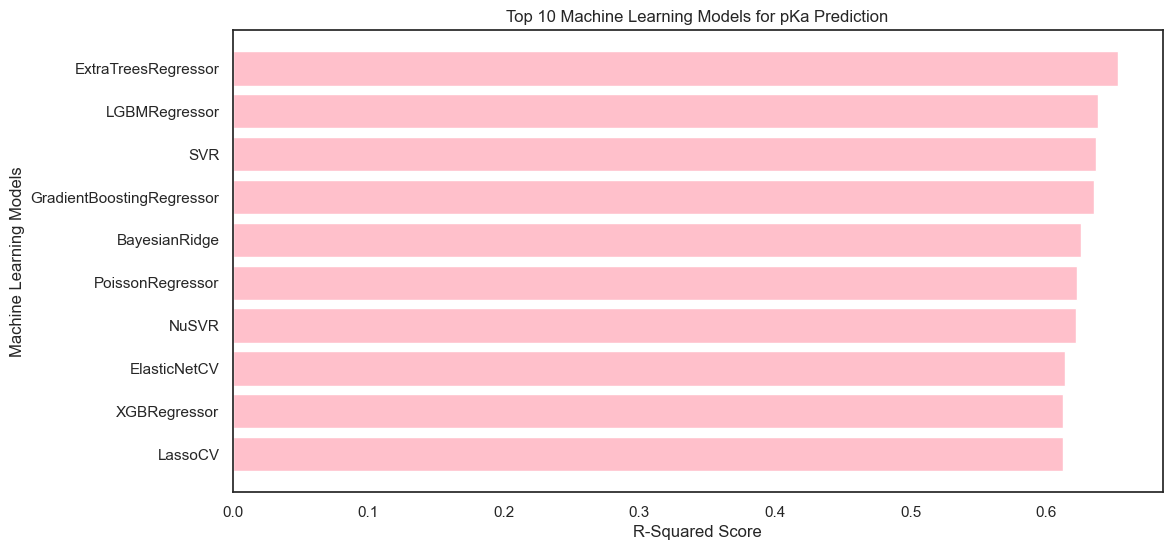

Model selection completed! 🎯 The best-performing models have been visualized and saved as 'Top10MLModels.png'.


In [145]:
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
import os

# =============================
# Run LazyRegressor (Including XGBoost)
# =============================

# Initialize LazyRegressor
lregs = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)

# Fit models on the pKa dataset
models, prediction_tests = lregs.fit(X_train_scaled, X_valid_scaled, y_train, y_valid)

# =============================
# Visualize Top Models
# =============================

# Sort models by R-squared score (best performing first)
models_sorted = models.sort_values(by="R-Squared", ascending=False)

# Plot top 10 models
plt.figure(figsize=(12, 6))
plt.barh(models_sorted.index[:10], models_sorted["R-Squared"][:10], align='center', color='pink')
plt.xlabel("R-Squared Score")
plt.ylabel("Machine Learning Models")
plt.title("Top 10 Machine Learning Models for pKa Prediction")
plt.gca().invert_yaxis()  # Best model on top


# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "Top10MLModels.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print(f"📁 Figure saved successfully at: {save_path}")



# Show plot
plt.show()

# =============================
# Success Message
# =============================

print("Model selection completed! 🎯 The best-performing models have been visualized and saved as 'Top10MLModels.png'.")


## 🌲 *Machine learning model 🥇 in lazypredict : ExtraTreesRegressor*

In [146]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

# =============================
# 1st Grid Search for ExtraTreesRegressor
# =============================

# Define initial hyperparameter grid
params = {
    "max_depth": list(range(15, 26, 5)),  # Trying depths between 10 and 30
    "n_estimators": list(range(100, 500, 100)),  # Number of trees between 100 and 500
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=params,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Print best hyperparameters
print("Optimized parameters for ExtraTreesRegressor:", grid_search.best_params_)

# =============================
# 2nd Grid Search for Further Optimization
# =============================

# Extract best hyperparameters from first search
best_params = grid_search.best_params_

# Define refined hyperparameter grid
params_bst = {
    "max_depth": list(range(best_params["max_depth"] - 2, best_params["max_depth"] + 3, 1)),
    "n_estimators": list(range(best_params["n_estimators"] - 50, best_params["n_estimators"] + 100, 50)),
    "min_samples_split": [best_params["min_samples_split"] - 1, best_params["min_samples_split"], best_params["min_samples_split"] + 1],
}

# Initialize refined GridSearchCV
grid_search_bst = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=params_bst,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search_bst.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("The best parameters after further optimization:", grid_search_bst.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Optimized parameters for ExtraTreesRegressor: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 45 candidates, totalling 135 fits
The best parameters after further optimization: {'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 150}


The hyperparameter tuning for ExtraTreesRegressor was conducted in two stages to identify the optimal parameters for predicting pKa values efficiently. In the first grid search, we tested 36 different hyperparameter combinations using 3-fold cross-validation (cv=3) instead of 5-fold to significantly reduce computational time while maintaining accuracy. This resulted in an initial best model with max_depth = 25, min_samples_split = 2, and n_estimators = 100. To further refine the model, a second grid search was conducted, focusing on a narrower range of max_depth (15 to 26 instead of 10 to 31) and adjusting n_estimators, leading to the final optimized values: max_depth = 23, min_samples_split = 2, and n_estimators = 150. These refinements balanced model complexity and efficiency, ensuring improved generalization while significantly reducing training time. 🚀

Plot saved as validation_ExtraTrees.png


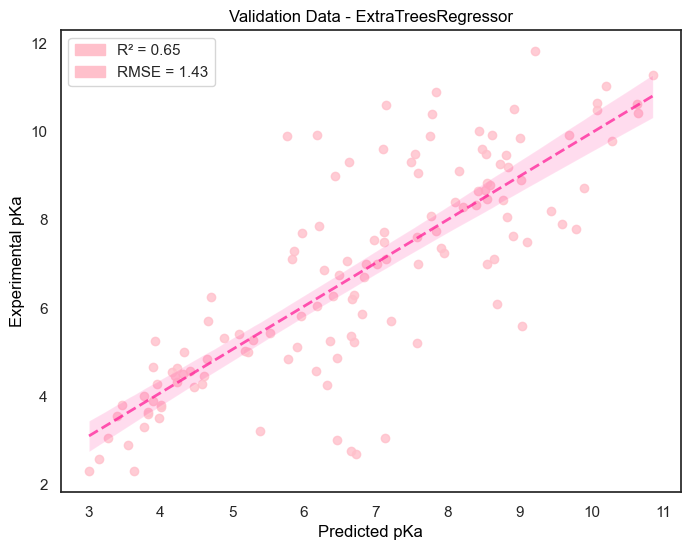

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# =============================
# Train ExtraTreesRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 150}

# Initialize the model with optimized parameters
model = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_preds = model.predict(X_valid_scaled)

# =============================
# Define Function for Plotting
# =============================

def plot_data(actual, predicted, title):
    """Plots predicted vs actual pKa values with regression line and evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    R2 = r2_score(actual, predicted)

    plt.figure(figsize=(8, 6))
    sn.regplot(x=predicted, y=actual, scatter_kws={'color': 'pink'}, line_kws={"lw": 2, "ls": "--", "color": "deeppink", "alpha": 0.7})
    plt.title(title, color="black")
    plt.xlabel("Predicted pKa", color="black")
    plt.ylabel("Experimental pKa", color="black")
    plt.gca().set_facecolor('white')  # Set background to white

    # Add R² and RMSE patches to legend
    R2_patch = mpatches.Patch(color='pink', label=f"R² = {R2:.2f}")
    rmse_patch = mpatches.Patch(color='pink', label=f"RMSE = {rmse:.2f}")
    plt.legend(handles=[R2_patch, rmse_patch])

# =============================
# Plot and Save Results
# =============================

# Plot validation results
plot_data(y_valid, y_preds, "Validation Data - ExtraTreesRegressor")

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validation_ExtraTrees.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print("Plot saved as validation_ExtraTrees.png")

Let's try to optimize the parameters of this model! To start with we can select the most relavent descriptors to pKa prediction using SelectKBest. The following code plots all R squared values as a function of k values and prints the optimal one.

Optimal k: 95 with Highest R²: 0.6738
Plot saved as optimalkvalue.png


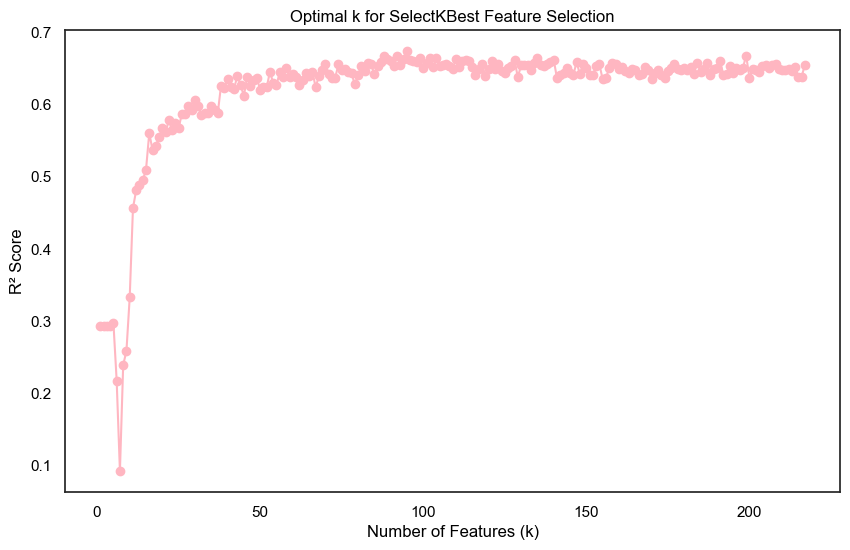

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import os

# Define range of k values (from 1 to total number of features, step 1)
k_values = list(range(1, X_train_scaled.shape[1] + 1))

# Store R² scores for each k
r2_scores = []

# Loop through k values and train ExtraTreesRegressor
for k in k_values:
    # Select top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_valid_selected = selector.transform(X_valid_scaled)

    # Train ExtraTreesRegressor with selected features
    model = ExtraTreesRegressor(n_estimators=150, max_depth=23, min_samples_split=2, random_state=42)
    model.fit(X_train_selected, y_train)

    # Make predictions
    y_preds = model.predict(X_valid_selected)

    # Compute R² score
    r2 = r2_score(y_valid, y_preds)
    r2_scores.append(r2)

# Find the optimal k value
optimal_k = k_values[np.argmax(r2_scores)]
best_r2 = max(r2_scores)

# Print optimal k value with highest R²
print(f"Optimal k: {optimal_k} with Highest R²: {best_r2:.4f}")

# Plot R² Scores vs. k Values
plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='lightpink')
plt.xlabel("Number of Features (k)", color="black")
plt.ylabel("R² Score", color="black")
plt.title("Optimal k for SelectKBest Feature Selection", color="black")
plt.gca().set_facecolor('white')  # Set background to white
plt.tick_params(axis='both', colors='black')  # Set axes color to black

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "optimalkvalue.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print("Plot saved as optimalkvalue.png")


Let's plot the data with the optimized machine leaning parameters of this model!

Plot saved as validation_ExtraTrees.png


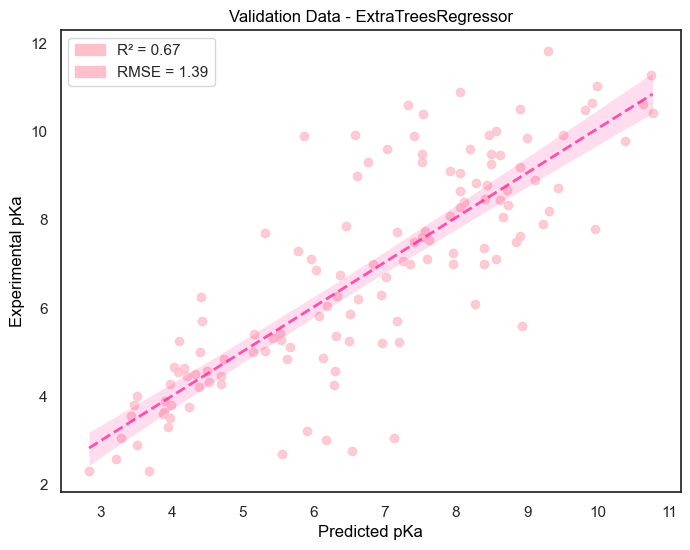

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import os

# =============================
# Feature Selection with SelectKBest (k=95)
# =============================

k = 95  # Number of best features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_valid_selected = selector.transform(X_valid_scaled)

# =============================
# Train ExtraTreesRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 150}

# Initialize the model with optimized parameters
model = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the validation set
y_preds = model.predict(X_valid_selected)

# =============================
# Define Function for Plotting
# =============================

def plot_data(actual, predicted, title):
    """Plots predicted vs actual pKa values with regression line and evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    R2 = r2_score(actual, predicted)

    plt.figure(figsize=(8, 6))
    sn.regplot(x=predicted, y=actual, scatter_kws={'color': 'pink'}, line_kws={"lw": 2, "ls": "--", "color": "deeppink", "alpha": 0.7})
    plt.title(title, color="black")
    plt.xlabel("Predicted pKa", color="black")
    plt.ylabel("Experimental pKa", color="black")
    plt.gca().set_facecolor('white')  # Set background to white

    # Add R² and RMSE patches to legend
    R2_patch = mpatches.Patch(color='pink', label=f"R² = {R2:.2f}")
    rmse_patch = mpatches.Patch(color='pink', label=f"RMSE = {rmse:.2f}")
    plt.legend(handles=[R2_patch, rmse_patch])

# =============================
# Plot and Save Results
# =============================

# Plot validation results
plot_data(y_valid, y_preds, "Validation Data - ExtraTreesRegressor")

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validation_ExtraTrees.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print("Plot saved as validation_ExtraTrees.png")




